### *사용할 종속성 catalog*

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tabulate

In [3]:
### 종속성 catalog
from tabulate import tabulate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker

In [5]:
# matplot 한글 깨짐 문제
# 해결방법 출처: https://mydevjourney.tistory.com/12
import matplotlib.font_manager as fm

# apt-get : 패키지 설치 명령어
# -qq : 에러외의 메세지 숨기는 옵션키
!apt-get -qq install fonts-nanum


fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정

## 1. BDA 개요

### 1. 데이터 개요 (메타데이터)
- 건강보험심사평가원_시군구별 성별 연령군별 주요 정신질환 진료 통계 (2023)
- 건강보험 진료일 기준으로 ADHD, 불면증, 불안장애, 우울증, 조울증, 조현병이 주상병으로 청구된 명세서 기준
- 1차 출처: http://opendata.hira.or.kr/op/opc/selectOpenData.do?sno=12800 (보건의료빅데이터개방시스템)
- 2차 출처: https://www.data.go.kr/data/15118810/fileData.do (공공데이터포털)

### 2. 데이터 구성 변수
1. 진료년도 : 2023년 자료이고, 모두 2023으로 통일되어 있음
2. 상병구분 : ADHD, 불면증, 불안장애, 우울증, 조울증, 조현병
3. 시도
4. 시군구
5. 성별
6. 연령군 (x0~ x9세 단위)
7. 환자수 : 10명 미만은 0으로 표시됨
8. 입내원일수
9. 요양급여비용총액

### 3. info(), head()

In [6]:
df = pd.read_csv('/content/drive/MyDrive/BDA/개인과제/건강보험심사평가원_시군구별 성별 연령군별 주요 정신질환 진료 통계 2023.csv', encoding='cp949')

# info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33506 entries, 0 to 33505
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   진료년도      33506 non-null  int64 
 1   상병구분      33506 non-null  object
 2   시도        33506 non-null  object
 3   시군구       33506 non-null  object
 4   성별        33506 non-null  object
 5   연령군       33506 non-null  object
 6   환자수       33506 non-null  int64 
 7   입내원일수     33506 non-null  int64 
 8   요양급여비용총액  33506 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 2.3+ MB


In [7]:
# 실제 데이터 확인
df.head()

,진료년도,상병구분,시도,시군구,성별,연령군,환자수,입내원일수,요양급여비용총액
0,2023,ADHD,서울,강남구,남,0~9세,980,6448,519912600
1,2023,ADHD,서울,강남구,남,10~19세,2295,17250,1509286940
2,2023,ADHD,서울,강남구,남,20~29세,1431,10151,1160302970
3,2023,ADHD,서울,강남구,남,30~39세,1137,8171,1033772760
4,2023,ADHD,서울,강남구,남,40~49세,312,2168,260667860


### 4. *분석 주제 (세부 질문)
- 상병구분과 관련된 질문
1. 상병구분별 요양급여비용총액이 가장 높은 상병은?
2. 상병구분별 환자수대비 입내원일수 평균이 가장 높은 상병은?
3. 상병구분별 총 환자수 순위는?
4. 상병구분별 환자수 1명당 요양급여비용총액이 가장 높은 상병은?

- 지역 관련 질문
5. 한 해 동안 요양급여비용총액이 가장 많이 지출된 지역은?
6. 한 해 동안 요양급여비용총액이 가장 적게 지출된 지역은?
7. (특정 지역 내 시군구별 요양급여비용총액 계산)

- 성별 관련 질문
8. 남성 환자수가 가장 많이 집계된 상병구분은?
9. 여성 환자수가 가장 많이 집계된 상병구분은?

- 연령대별 질문
10. 연령대별로 가장 많이 집계된 상병구분은 무엇인가? (남녀 구분X, 생애주기)

## 데이터 전처리
- 33506개 인스턴스에서 결측치가 존재하지 않고 정리된 데이터이기 때문에 별다른 전처리를 거칠 필요가 없어보임.
- 그러나 [진료년도]의 경우에는 모든 row가 2023이기 때문에 의미상 필요가 없음 -> 삭제

In [8]:
del df['진료년도']

## 1. 상병구분

### 상병구분별 요양급여비용총액 순위

In [9]:
# 상병구분별 요양급여비용총액 합계 계산
cost_by_disease = df.groupby('상병구분')['요양급여비용총액'].sum()

# 요양급여비용총액 내림차순 정렬
sorted_cost_by_disease = cost_by_disease.sort_values(ascending=False)

# 요양급여비용총액과 함께 출력
for disease, cost in sorted_cost_by_disease.items():
    print(f"{disease}: {cost:,.0f}원") # 천 단위 구분 기호 추가

우울증: 604,212,411,730원
조현병: 408,834,900,740원
불안장애: 294,970,386,250원
조울증: 144,409,110,610원
ADHD: 137,345,580,610원
불면증: 102,538,116,830원


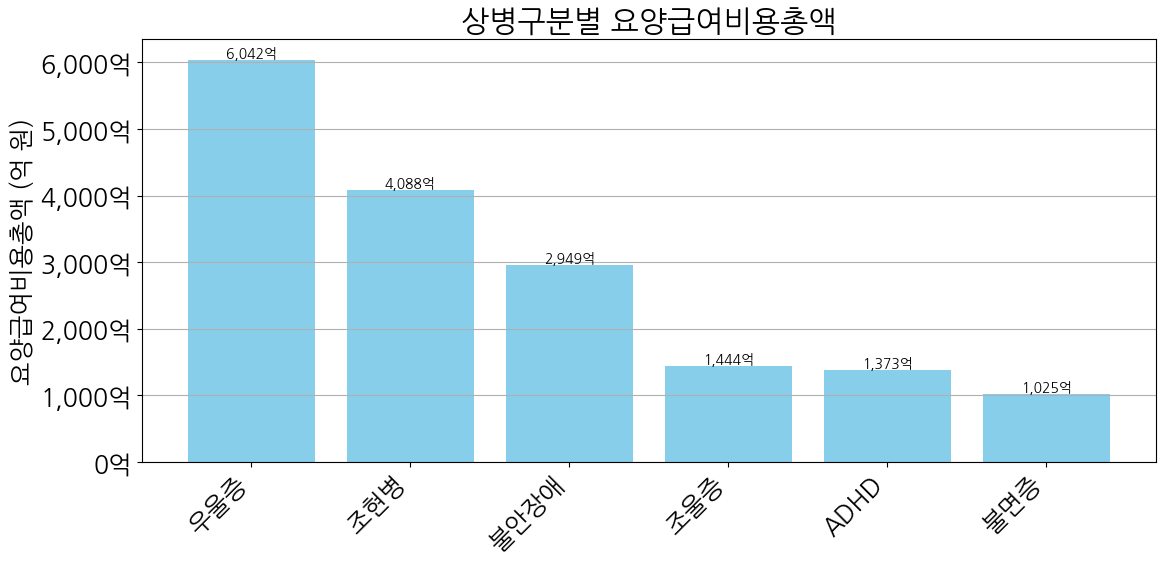

In [10]:
# 상병구분과 요양급여비용총액을 리스트로 변환
diseases = sorted_cost_by_disease.index
costs = sorted_cost_by_disease.values

# 막대 그래프 그리기
plt.figure(figsize=(12, 6))
bars = plt.bar(diseases, costs, color='skyblue')  # bars 변수 정의
plt.ylabel('요양급여비용총액 (억 원)')
plt.title('상병구분별 요양급여비용총액')
plt.xticks(rotation=45, ha='right')  # x축 레이블 회전

# y축 포맷팅
formatter = ticker.FuncFormatter(lambda x, pos: f'{int(x / 1e8):,}억')
plt.gca().yaxis.set_major_formatter(formatter)

# 각 바 위에 값 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{int(yval / 1e8):,}억',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()  # 레이아웃 조정
plt.grid(axis='y')  # y축에 그리드 추가
plt.show()


### 상병구분별 환자수대비 입내원일수 평균 순위

In [11]:
# 환자수 대비 입내원일수 계산
df['환자수'] = df['환자수'].replace(0, np.nan) # 0값을 NaN으로 변환하여 계산에서 제외
df['입내원일수_대비_환자수'] = df['입내원일수'] / df['환자수']

# 상병구분별 입내원일수 평균 계산
disease_avg_days = df.groupby('상병구분')['입내원일수_대비_환자수'].mean()

# 내림차순으로 정렬
sorted_disease_avg_days = disease_avg_days.sort_values(ascending=False)

# 결과 출력
for disease, avg_days in sorted_disease_avg_days.items():
    print(f"상병구분: {disease}, 입내원일수 평균: {avg_days:.2f}")

상병구분: 조현병, 입내원일수 평균: 33.53
상병구분: 조울증, 입내원일수 평균: 11.13
상병구분: 우울증, 입내원일수 평균: 7.00
상병구분: ADHD, 입내원일수 평균: 6.48
상병구분: 불안장애, 입내원일수 평균: 4.80
상병구분: 불면증, 입내원일수 평균: 3.67


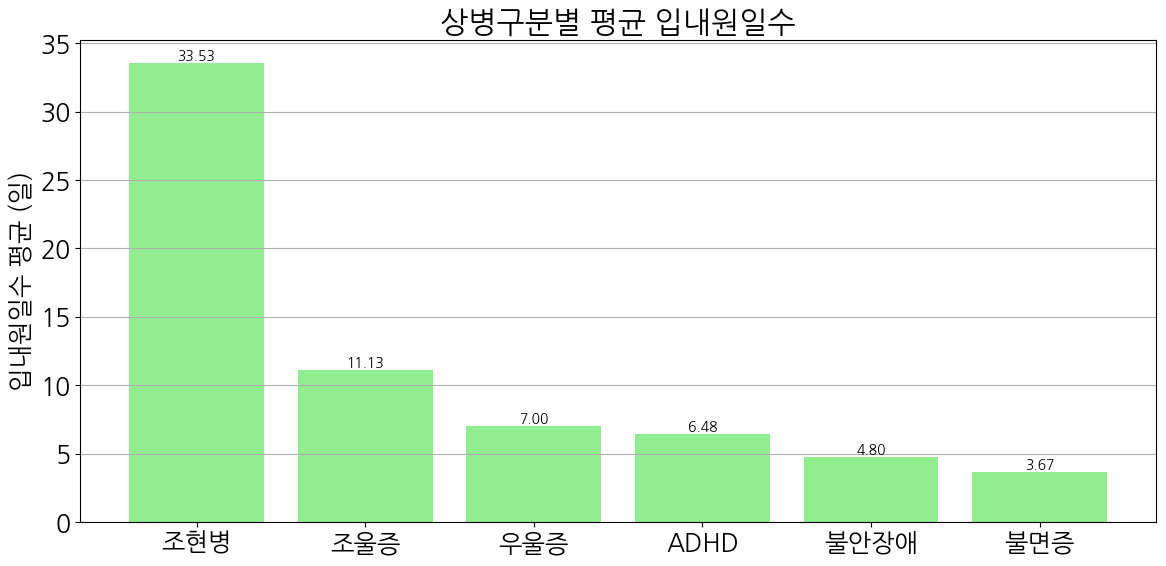

In [12]:
# 상병구분과 입내원일수 평균을 리스트로 변환
diseases = sorted_disease_avg_days.index
avg_days = sorted_disease_avg_days.values

# 막대 그래프 그리기
plt.figure(figsize=(12, 6))
bars = plt.bar(diseases, avg_days, color='lightgreen')
plt.ylabel('입내원일수 평균 (일)')
plt.title('상병구분별 평균 입내원일수')
#plt.xticks(rotation=45, ha='right')  # x축 레이블 회전

# 각 바 위에 값 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()  # 레이아웃 조정
plt.grid(axis='y')  # y축에 그리드 추가
plt.show()


### 상병구분별 총 환자수 순위

In [13]:
# 상병구분별 환자수 합계 계산
patient_count_by_disease = df.groupby('상병구분')['환자수'].sum()

# 환자수 내림차순 정렬
sorted_patient_count = patient_count_by_disease.sort_values(ascending=False)

# 환자수와 함께 출력
for disease, patient_count in sorted_patient_count.items():
    print(f"{disease}: {patient_count:,.0f}명") # 천 단위 구분 기호 추가

우울증: 1,149,979명
불안장애: 951,895명
불면증: 801,105명
ADHD: 225,658명
조울증: 152,975명
조현병: 138,616명


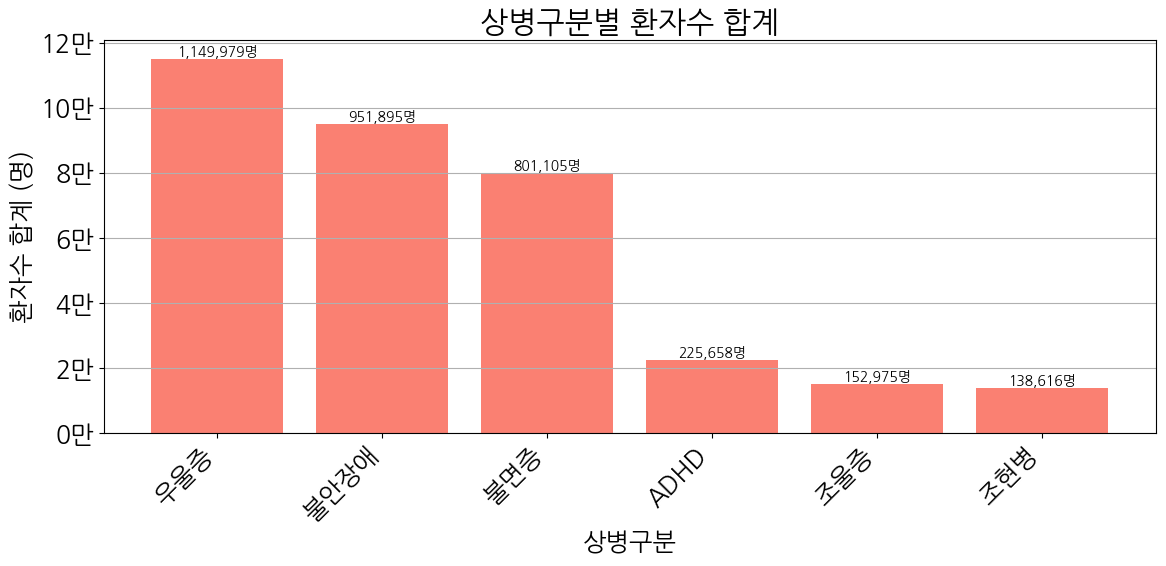

In [14]:
# 상병구분과 환자수를 리스트로 변환
diseases = sorted_patient_count.index
patient_counts = sorted_patient_count.values

# 막대 그래프 그리기
plt.figure(figsize=(12, 6))
bars = plt.bar(diseases, patient_counts, color='salmon')
plt.xlabel('상병구분')
plt.ylabel('환자수 합계 (명)')
plt.title('상병구분별 환자수 합계')
plt.xticks(rotation=45, ha='right')  # x축 레이블 회전

# y축 포맷팅 (10만 단위)
formatter = ticker.FuncFormatter(lambda x, pos: f'{int(x / 1e5):,}만')
plt.gca().yaxis.set_major_formatter(formatter)

# 각 바 위에 값 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{int(yval):,}명',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()  # 레이아웃 조정
plt.grid(axis='y')  # y축에 그리드 추가
plt.show()

### 상병구분별 환자수 1명당 요양급여비용총액

조현병: 2,949,406원
조울증: 944,005원
ADHD: 608,645원
우울증: 525,412원
불안장애: 309,877원
불면증: 127,996원


<ipython-input-15-055d827cbca3>:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


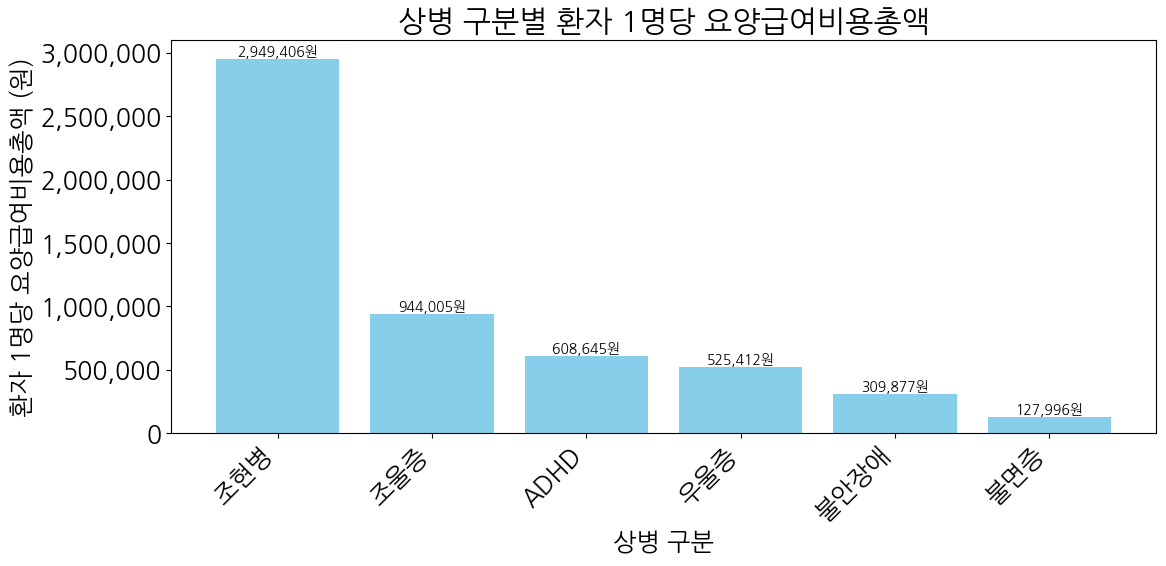

In [15]:
# 상병구분별 환자수 합계 계산
patient_count_by_disease = df.groupby('상병구분')['환자수'].sum()

# 상병구분별 요양급여비용총액 합계 계산
cost_by_disease = df.groupby('상병구분')['요양급여비용총액'].sum()

# 환자 1명당 요양급여비용총액 계산
cost_per_patient = cost_by_disease / patient_count_by_disease

# 내림차순으로 정렬
sorted_cost_per_patient = cost_per_patient.sort_values(ascending=False)

# 결과 출력 (천 단위 구분 기호 추가)
for disease, cost in sorted_cost_per_patient.items():
    print(f"{disease}: {cost:,.0f}원")

# 시각화
plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_cost_per_patient.index, sorted_cost_per_patient.values, color='skyblue')
plt.xlabel("상병 구분")
plt.ylabel("환자 1명당 요양급여비용총액 (원)")
plt.title("상병 구분별 환자 1명당 요양급여비용총액")
plt.xticks(rotation=45, ha='right')

# y축 값에 쉼표 추가
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

# 각 바 위에 값 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:,.0f}원',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 2. 지역별


### 1. 특정 지역 내 시군구별 요양급여비용총액 계산기

In [16]:
import locale

# 지역 이름(예: '서울')을 입력받아 해당 지역의 시군구별 요양급여비용총액을 내림차순 출력하는 함수
def get_cost_by_region(df, region):
    # 해당 지역 데이터 필터링
    region_df = df[df['시도'] == region]

    # 시군구별 요양급여비용총액 계산
    cost_by_sigungu = region_df.groupby('시군구')['요양급여비용총액'].sum()

    # 내림차순 정렬
    sorted_cost_by_sigungu = cost_by_sigungu.sort_values(ascending=False)

    # DataFrame으로 변환
    result_df = sorted_cost_by_sigungu.reset_index()
    result_df.columns = ['시군구', '요양급여비용총액']

    # Set locale for formatting
    locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')  # Or use '' for auto

    # Apply formatting to the column
    result_df['요양급여비용총액'] = result_df['요양급여비용총액'].apply(lambda x: locale.format_string("%d", x, grouping=True))

    # 표 출력
    print(f"\n{region} 시군구별 요양급여비용총액 (내림차순):\n")
    print(tabulate(result_df, headers='keys', tablefmt='grid', showindex=False))

# 함수 호출
get_cost_by_region(df, '서울')


서울 시군구별 요양급여비용총액 (내림차순):

+----------+--------------------+
| 시군구   | 요양급여비용총액   |
+==========+====================+
| 강남구   | 57,970,863,740     |
+----------+--------------------+
| 송파구   | 37,491,669,750     |
+----------+--------------------+
| 서초구   | 34,568,769,540     |
+----------+--------------------+
| 종로구   | 24,982,359,260     |
+----------+--------------------+
| 마포구   | 23,262,546,840     |
+----------+--------------------+
| 영등포구 | 20,824,818,140     |
+----------+--------------------+
| 광진구   | 20,037,689,030     |
+----------+--------------------+
| 동대문구 | 19,739,471,350     |
+----------+--------------------+
| 강서구   | 17,711,760,770     |
+----------+--------------------+
| 강동구   | 16,885,750,530     |
+----------+--------------------+
| 중랑구   | 16,733,803,340     |
+----------+--------------------+
| 관악구   | 16,489,969,290     |
+----------+--------------------+
| 동작구   | 16,404,841,200     |
+----------+--------------------+
| 구로구   | 15,357,971,860     |
+-------

### 2. 한 해 동안 요양급여비용을 가장 많이 지출한 지역

요양급여비용총액 Top 3 지역:
서울 - 강남구: 57,970,863,740원
서울 - 송파구: 37,491,669,750원
서울 - 서초구: 34,568,769,540원


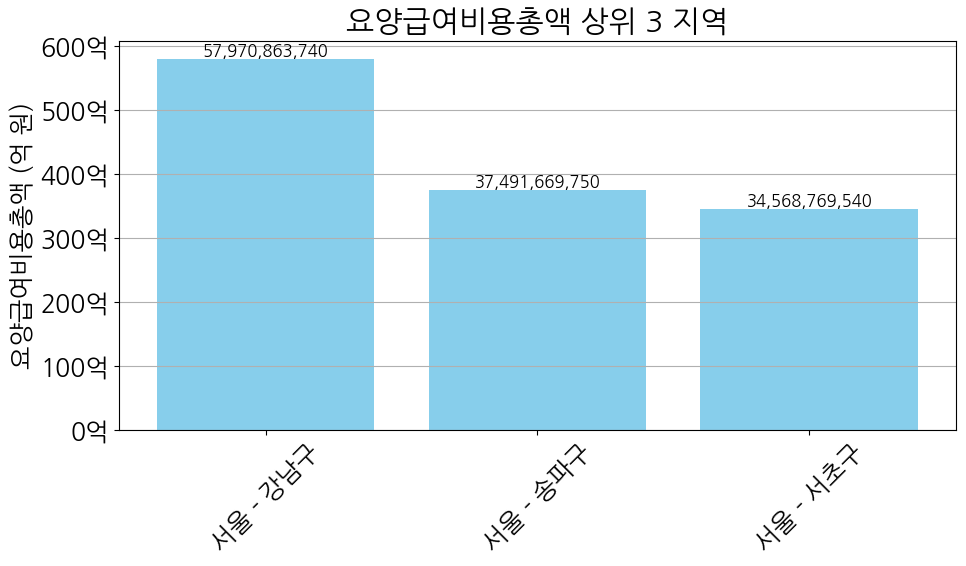

In [17]:
def format_y_ticks(x, _):
    return f'{int(x / 100000000):,}억'  # 억 단위로 변환

def visualize_top_cost_by_region(df):
    # 지역과 시군구를 하나의 축으로 묶고 요양급여비용의 총합을 계산
    cost_by_region = df.groupby(['시도', '시군구'])['요양급여비용총액'].sum()

    # 요양급여비용총액을 기준으로 내림차순 정렬
    sorted_cost_by_region = cost_by_region.sort_values(ascending=False)

    # 상위 3개 지역 선택
    top_costs = sorted_cost_by_region.head(3)

    # 결과 출력
    print("요양급여비용총액 Top 3 지역:")
    for (region, sigungu), cost in top_costs.items():
        print(f"{region} - {sigungu}: {cost:,.0f}원")

    # 시각화
    plt.figure(figsize=(10, 6))
    bars = plt.bar(top_costs.index.map(lambda x: f"{x[0]} - {x[1]}"), top_costs, color='skyblue')
    plt.title('요양급여비용총액 상위 3 지역')
    plt.ylabel('요양급여비용총액 (억 원)')
    plt.xticks(rotation=45)

    # y축 레이블을 억 단위로 포맷팅
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_y_ticks))

    # 각 막대 위에 레이블 추가
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{int(yval):,}',
                 ha='center', va='bottom', fontsize=12)

    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# 함수 호출
visualize_top_cost_by_region(df)

### 3. 한 해 동안 요양급여비용을 가장 적게 지출한 지역

요양급여비용총액 Bottom 3 지역:
인천 - 인천옹진군: 1,061,830원
경북 - 울릉군: 2,820,570원
경북 - 영양군: 3,249,010원


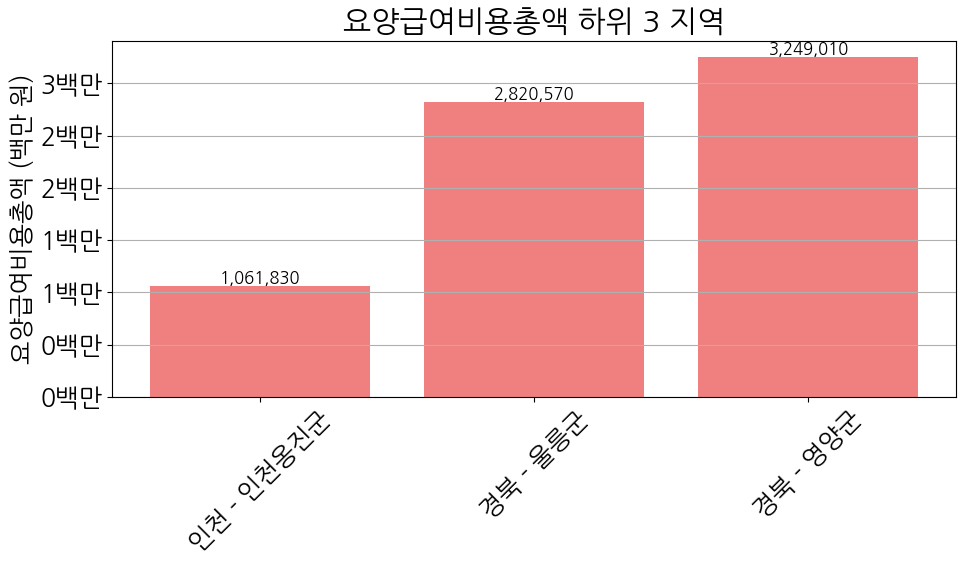

In [18]:
def format_y_ticks(x, _):
    return f'{int(x / 1000000):,}백만'  # 100만원 단위로 변환

def visualize_bottom_cost_by_region(df):
    # 지역과 시군구를 하나의 축으로 묶고 요양급여비용의 총합을 계산
    cost_by_region = df.groupby(['시도', '시군구'])['요양급여비용총액'].sum()

    # 요양급여비용총액을 기준으로 오름차순 정렬
    sorted_cost_by_region = cost_by_region.sort_values(ascending=True)

    # 하위 3개 지역 선택
    bottom_costs = sorted_cost_by_region.head(3)

    # 결과 출력
    print("요양급여비용총액 Bottom 3 지역:")
    for (region, sigungu), cost in bottom_costs.items():
        print(f"{region} - {sigungu}: {cost:,.0f}원")

    # 시각화
    plt.figure(figsize=(10, 6))
    bars = plt.bar(bottom_costs.index.map(lambda x: f"{x[0]} - {x[1]}"), bottom_costs, color='lightcoral')
    plt.title('요양급여비용총액 하위 3 지역')
    plt.ylabel('요양급여비용총액 (백만 원)')
    plt.xticks(rotation=45)

    # y축 레이블을 100만원 단위로 포맷팅
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_y_ticks))

    # 각 막대 위에 레이블 추가
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{int(yval):,}',
                 ha='center', va='bottom', fontsize=12)

    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# 함수 호출
visualize_bottom_cost_by_region(df)

## 3. 성별


### 성별 상위 환자수 상병구분

여성 환자수 상위 상병구분:
우울증: 777,580명
불안장애: 580,942명
불면증: 484,627명
조울증: 95,180명
ADHD: 81,344명
조현병: 77,591명


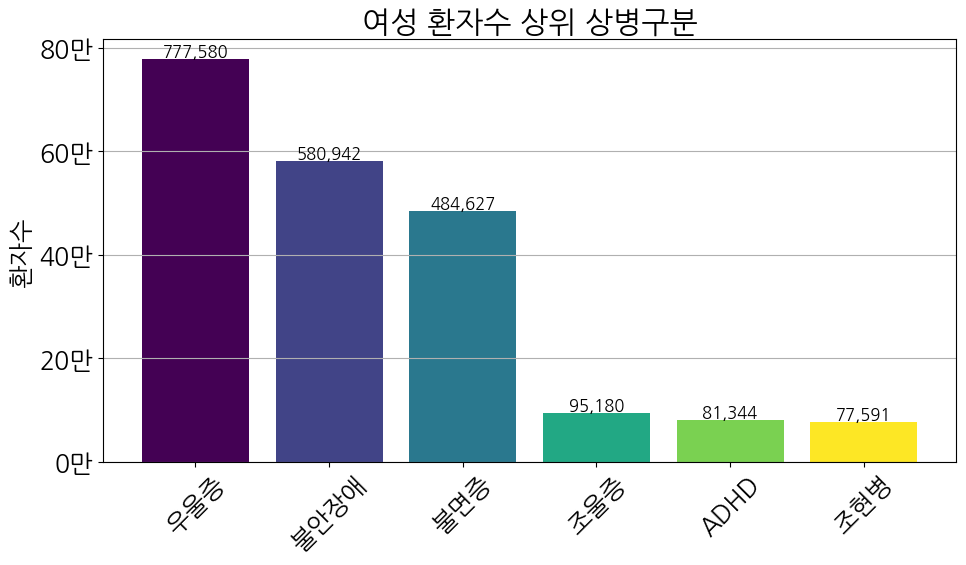

남성 환자수 상위 상병구분:
우울증: 372,399명
불안장애: 370,953명
불면증: 316,478명
ADHD: 144,314명
조현병: 61,025명
조울증: 57,795명


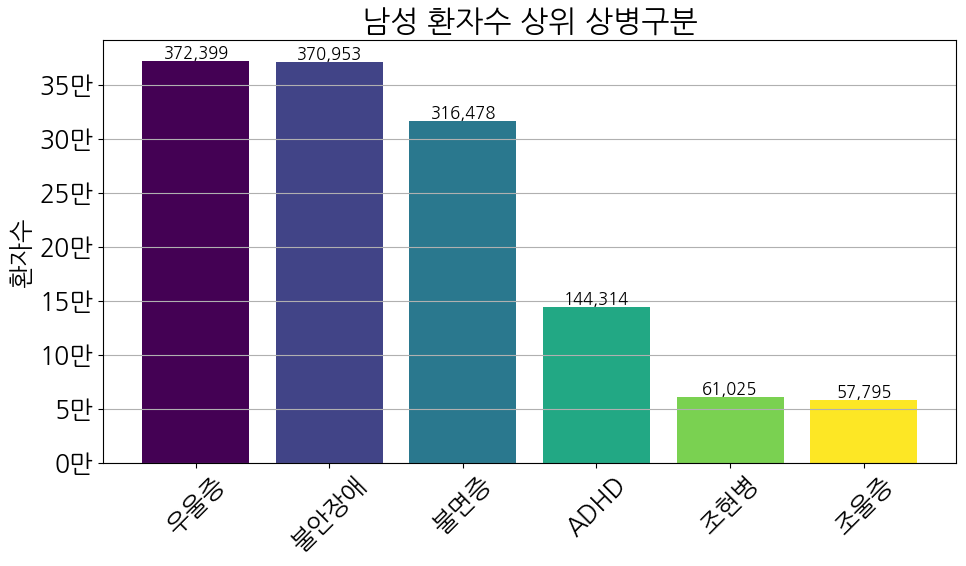

In [19]:
def format_y_ticks(x, _):
    return f'{int(x / 10000):,}만'  # 만 단위로 변환

def get_top_diseases_by_gender(df, gender):
    # 입력받은 성별 데이터만 필터링
    filtered_df = df[df['성별'] == gender]

    # 성별 데이터에서 상병구분별 환자수 합계 계산
    patient_count_by_disease = filtered_df.groupby('상병구분')['환자수'].sum()

    # 환자수 내림차순으로 정렬
    sorted_patient_count = patient_count_by_disease.sort_values(ascending=False)

    # 결과 출력
    print(f"{gender}성 환자수 상위 상병구분:")
    for disease, patient_count in sorted_patient_count.items():
        print(f"{disease}: {patient_count:,.0f}명")

    # 색상 설정
    colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_patient_count)))

    # 시각화
    plt.figure(figsize=(10, 6))
    bars = plt.bar(sorted_patient_count.index, sorted_patient_count, color=colors)
    plt.title(f'{gender}성 환자수 상위 상병구분')
    plt.ylabel('환자수')
    plt.xticks(rotation=45)
    # 각 막대 위에 레이블 추가
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{int(yval):,.0f}',
                 ha='center', va='bottom', fontsize=12)  # 레이블 중앙 정렬, 막대 위에 표시

    # y축 레이블을 만 단위로 포맷팅
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_y_ticks))

    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# 함수 호출
get_top_diseases_by_gender(df, '여')
get_top_diseases_by_gender(df, '남')


## 4. 연령대별

### 연령대별 상병구분별 환자수

<ipython-input-20-12e9e0a66e29>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{int(y/10000)}' for y in ax.get_yticks()])


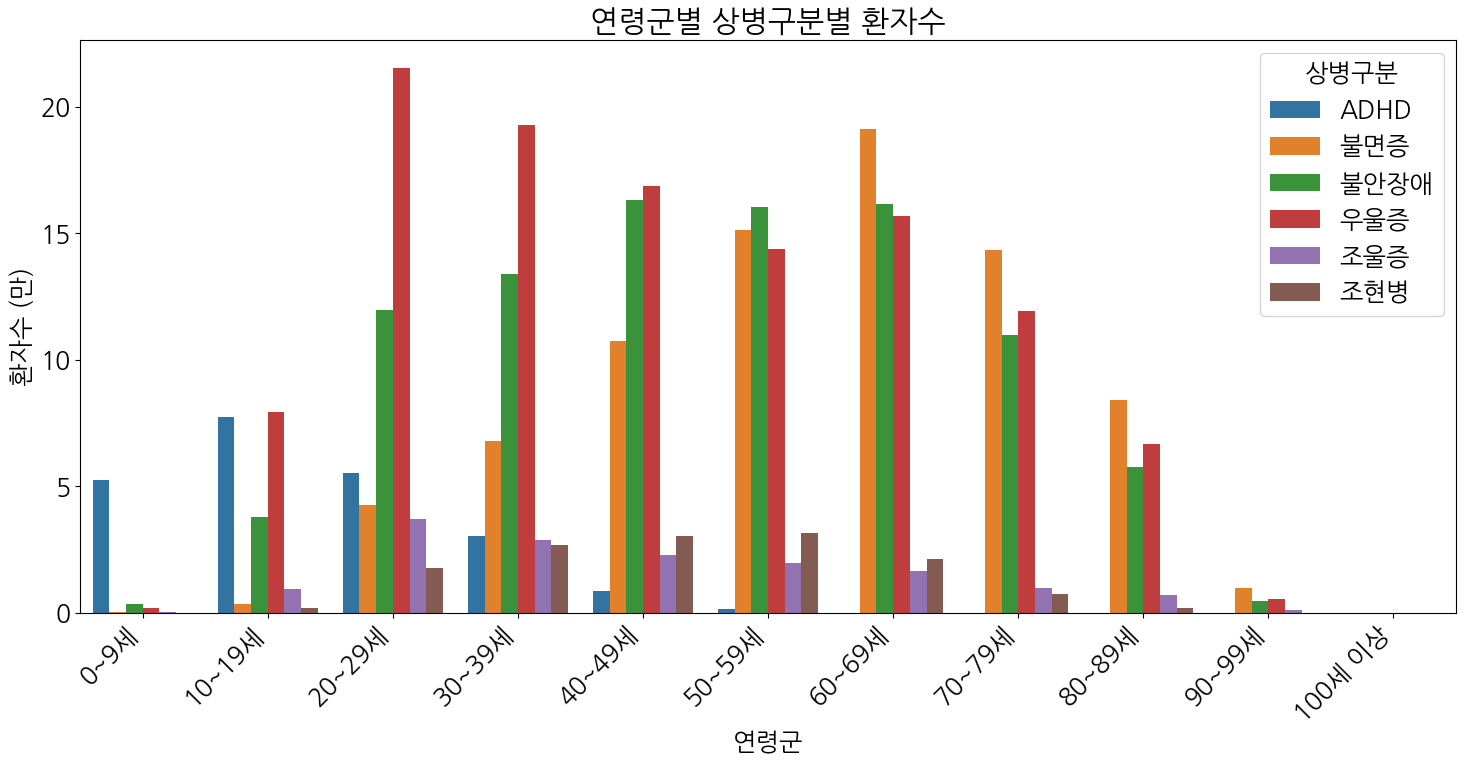

In [20]:
# 연령군별 상병구분별 환자수를 matplotlib 막대 그래프로 출력
plt.figure(figsize=(15, 8))  # 그래프 크기 조정
ax = sns.barplot(x='연령군', y='환자수', hue='상병구분', data=df, errorbar=None, estimator=sum)

plt.title('연령군별 상병구분별 환자수')
plt.xlabel('연령군')
plt.ylabel('환자수 (만)')
plt.xticks(rotation=45, ha='right') # x축 레이블 회전

# y축 레이블에 "(만)" 단위 추가
ax.set_yticklabels([f'{int(y/10000)}' for y in ax.get_yticks()])

plt.tight_layout()
plt.show()